# Exploratory Data Analysis - 2: Bivariate Analysis, Feature Engineering and Missing Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
train_df = pd.read_csv(
    "data/train.csv", parse_dates=["Scheduled Date", "Delivery Date"]
)

<IPython.core.display.Javascript object>

In [3]:
test_df = pd.read_csv("data/test.csv", parse_dates=["Scheduled Date", "Delivery Date"])

<IPython.core.display.Javascript object>

In [4]:
TUNING = 0

<IPython.core.display.Javascript object>

## Treating Missing Data

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Customer Id            6500 non-null   object        
 1   Artist Name            6500 non-null   object        
 2   Artist Reputation      5750 non-null   float64       
 3   Height                 6125 non-null   float64       
 4   Width                  5916 non-null   float64       
 5   Weight                 5913 non-null   float64       
 6   Material               5736 non-null   object        
 7   Price Of Sculpture     6500 non-null   float64       
 8   Base Shipping Price    6500 non-null   float64       
 9   International          6500 non-null   object        
 10  Express Shipment       6500 non-null   object        
 11  Installation Included  6500 non-null   object        
 12  Transport              5108 non-null   object        
 13  Fra

<IPython.core.display.Javascript object>

We can immediately identify some of the missing columns as:
* `Artist Reputation`
* `Height`
* `Width`
* `Weight`
* `Material`
* `Transport`
* `Remote Location`

Missing values "can have a significant effect on the conclusions that can be drawn from the data" [1]. We need to figure out whether to drop these or imputate them based on how they can impact the results drawn by our model.

This article Towards Data Science [2], explains the different ways the data can be missing. These are:
1. Missing at random - there is a systematic relationship between the propensity of missing values and the observed data, but not the missing data
2. Missing Completely at Random - no relationship between the missingness of the data and any values, observed or missing
3. Missing Not at Random - data is missing is related to the unobserved data

In [6]:
missing_values_df = (train_df.isna().sum() / train_df.shape[0] * 100).reset_index()

<IPython.core.display.Javascript object>

In [7]:
missing_values_df[missing_values_df[0] > 0]

,index,0
2,Artist Reputation,11.538462
3,Height,5.769231
4,Width,8.984615
5,Weight,9.030769
6,Material,11.753846
12,Transport,21.415385
15,Remote Location,11.861538


<IPython.core.display.Javascript object>

### Univariate Analysis of Missing data wrt Target variable

The easiest to do is to check if there's a relationship between the missing values itself and the target variable

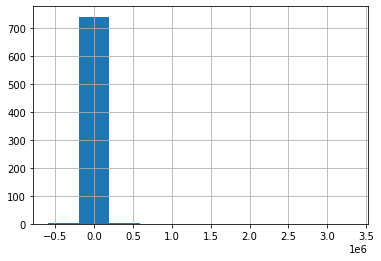

<IPython.core.display.Javascript object>

In [8]:
plt.hist(train_df.loc[train_df["Artist Reputation"].isna(), "Cost"])
plt.grid()
plt.show()

Most of Cost seem to be distributed around 0, but this is also the cast with the non-missing values. Hence there's no relationship here.

In [9]:
train_df.loc[train_df["Artist Reputation"].isna(), "Cost"].describe(
    percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
)

count    7.500000e+02
mean     1.555013e+04
std      1.800113e+05
min     -5.881832e+05
10%      7.884600e+01
25%      1.824700e+02
50%      3.659600e+02
75%      1.167327e+03
90%      5.173631e+03
95%      1.786683e+04
99%      2.145674e+05
max      3.324867e+06
Name: Cost, dtype: float64

<IPython.core.display.Javascript object>

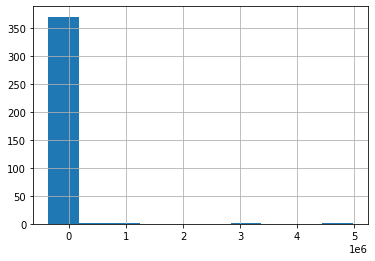

<IPython.core.display.Javascript object>

In [10]:
plt.hist(train_df.loc[train_df["Height"].isna(), "Cost"])
plt.grid()
plt.show()

In [11]:
train_df.loc[train_df["Height"].isna(), "Cost"].describe(
    percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
)

count    3.750000e+02
mean     2.731979e+04
std      3.153483e+05
min     -3.608145e+05
10%      1.159240e+02
25%      1.882250e+02
50%      3.916100e+02
75%      1.195765e+03
90%      5.949440e+03
95%      1.713534e+04
99%      2.149380e+05
max      4.976101e+06
Name: Cost, dtype: float64

<IPython.core.display.Javascript object>

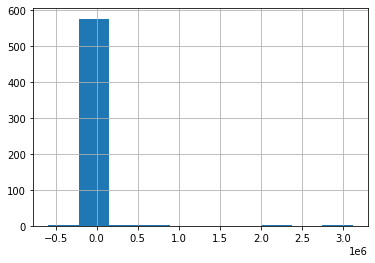

<IPython.core.display.Javascript object>

In [12]:
plt.hist(train_df.loc[train_df["Width"].isna(), "Cost"])
plt.grid()
plt.show()

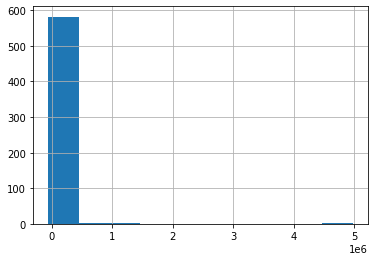

<IPython.core.display.Javascript object>

In [13]:
plt.hist(train_df.loc[train_df["Weight"].isna(), "Cost"])
plt.grid()
plt.show()

In [14]:
train_df.loc[train_df["Weight"].isna(), "Cost"].describe(
    percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
)

count    5.870000e+02
mean     1.768451e+04
std      2.197743e+05
min     -5.766298e+04
10%     -1.590600e+02
25%      1.875200e+02
50%      3.657300e+02
75%      1.118590e+03
90%      5.019574e+03
95%      1.680177e+04
99%      1.602159e+05
max      4.976101e+06
Name: Cost, dtype: float64

<IPython.core.display.Javascript object>

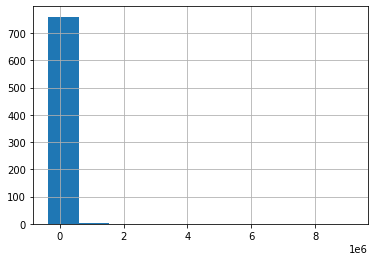

<IPython.core.display.Javascript object>

In [15]:
plt.hist(train_df.loc[train_df["Material"].isna(), "Cost"])
plt.grid()
plt.show()

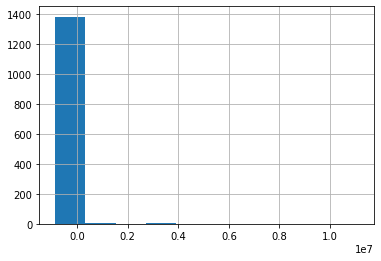

<IPython.core.display.Javascript object>

In [16]:
plt.hist(train_df.loc[train_df["Transport"].isna(), "Cost"])
plt.grid()
plt.show()

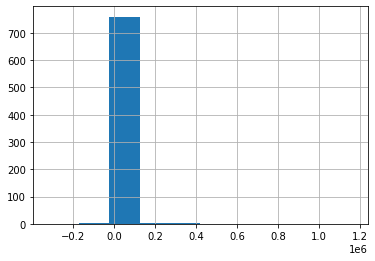

<IPython.core.display.Javascript object>

In [17]:
plt.hist(train_df.loc[train_df["Remote Location"].isna(), "Cost"])
plt.grid()
plt.show()

There seems to be no apparent relationship with the missing variables values and the target variable "Cost".

### `Artist Reputation`

In [18]:
train_df["Artist Reputation"].isna().sum()

750

<IPython.core.display.Javascript object>

There are 750 rows with missing Artist Reputations. We can fill this up using information based on these columns:
1. `Price Of Sculpture`
2. `Base Shipping Price`

Neither of these columns have any NA values. We can use `RandomForests` to fill the NAs.

In [19]:
artist_rep_train_df = train_df.loc[
    ~train_df["Artist Reputation"].isna(),
    ["Artist Reputation", "Price Of Sculpture", "Base Shipping Price"],
]

artist_rep_test_df = train_df.loc[
    train_df["Artist Reputation"].isna(),
    ["Artist Reputation", "Price Of Sculpture", "Base Shipping Price"],
]

<IPython.core.display.Javascript object>

In [20]:
(
    artist_rep_X_train,
    artist_rep_X_val,
    artist_rep_y_train,
    artist_rep_y_val,
) = train_test_split(
    artist_rep_train_df.drop(["Artist Reputation"], axis=1),
    artist_rep_train_df[["Artist Reputation"]],
    test_size=0.40,
    random_state=42,
)

<IPython.core.display.Javascript object>

In [21]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
# Number of features to consider at every split
max_features = ["auto", "sqrt"]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}

<IPython.core.display.Javascript object>

In [22]:
artist_rep_na_val_regr = RandomForestRegressor()

<IPython.core.display.Javascript object>

In [23]:
rf_random = RandomizedSearchCV(
    estimator=artist_rep_na_val_regr,
    param_distributions=random_grid,
    n_iter=100,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)

<IPython.core.display.Javascript object>

In [24]:
if TUNING:
    rf_random.fit(
        artist_rep_X_train,
        artist_rep_y_train,
    )

<IPython.core.display.Javascript object>

In [25]:
if TUNING:
    print(rf_random.best_params_)

<IPython.core.display.Javascript object>

In [26]:
if TUNING:
    base_model = RandomForestRegressor(n_estimators=10, random_state=42)
    base_model.fit(artist_rep_X_train, artist_rep_y_train)
    artist_rep_y_pred = base_model.predict(artist_rep_X_val)
    mean_squared_error(artist_rep_y_val, artist_rep_y_pred)

<IPython.core.display.Javascript object>

In [27]:
if TUNING:
    best_random = rf_random.best_estimator_
    artist_rep_y_pred = best_random.predict(artist_rep_X_val)
    print(mean_squared_error(artist_rep_y_val, artist_rep_y_pred))

<IPython.core.display.Javascript object>

* Best random estimator using `RandomizedSearchCV` has a 25% lower MSE than the default Random Forest hyperparameters.
* Creating the parameter grid based on the results of random search

```json
{
    "n_estimators": 1000,
    "min_samples_split": 10,
    "min_samples_leaf": 2,
    "max_features": "sqrt",
    "max_depth": 10,
    "bootstrap": True,
}
```

In [28]:
param_grid = {
    "bootstrap": [True],
    "max_depth": [10, 20, 30, 40],
    "max_features": [2, 3],
    "min_samples_leaf": [2, 3, 4],
    "min_samples_split": [9, 10, 11],
    "n_estimators": [900, 1000, 1100, 1200],
}

<IPython.core.display.Javascript object>

In [29]:
# Create a base model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(
    estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2
)

<IPython.core.display.Javascript object>

In [30]:
if TUNING:
    # Fit the grid search to the data
    grid_search.fit(artist_rep_X_train, artist_rep_y_train)

<IPython.core.display.Javascript object>

In [31]:
if TUNING:
    print(grid_search.best_params_)

<IPython.core.display.Javascript object>

* Best hyperparameters using GridSearchCV are:

```json
{
    "bootstrap": True,
    "max_depth": 10,
    "max_features": 2,
    "min_samples_leaf": 2,
    "min_samples_split": 10,
    "n_estimators": 1100,
}
```

In [32]:
if TUNING:
    best_grid = grid_search.best_estimator_
    best_grid.fit(artist_rep_X_train, artist_rep_y_train)
    artist_rep_y_pred = best_grid.predict(artist_rep_X_val)
    print(mean_squared_error(artist_rep_y_val, artist_rep_y_pred))

<IPython.core.display.Javascript object>

In [33]:
# Creating a RF regressor
artist_rep_rf = RandomForestRegressor(
    **{
        "bootstrap": True,
        "max_depth": 10,
        "max_features": "sqrt",
        "min_samples_leaf": 2,
        "min_samples_split": 10,
        "n_estimators": 1100,
    }
)

<IPython.core.display.Javascript object>

In [34]:
artist_rep_rf.fit(artist_rep_X_train, artist_rep_y_train)
artist_rep_y_pred = artist_rep_rf.predict(artist_rep_X_val)
mean_squared_error(artist_rep_y_val, artist_rep_y_pred)

<ipython-input-34-411004291cb1>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  artist_rep_rf.fit(artist_rep_X_train, artist_rep_y_train)


0.06801033085801646

<IPython.core.display.Javascript object>

In [35]:
artist_rep_rf.fit(
    artist_rep_train_df[["Base Shipping Price", "Price Of Sculpture"]],
    artist_rep_train_df[["Artist Reputation"]],
)

<ipython-input-35-9413ea736aa4>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  artist_rep_rf.fit(


RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=10, n_estimators=1100)

<IPython.core.display.Javascript object>

In [36]:
train_df.loc[
    train_df["Artist Reputation"].isna(),
    ["Artist Reputation"],
] = artist_rep_rf.predict(
    train_df.loc[
        train_df["Artist Reputation"].isna(),
        ["Price Of Sculpture", "Base Shipping Price"],
    ]
)

<IPython.core.display.Javascript object>

In [37]:
train_df[["Price Of Sculpture", "Base Shipping Price", "Artist Reputation"]].sample(5)

,Price Of Sculpture,Base Shipping Price,Artist Reputation
4545,6.65,21.59,0.12
1692,5.90,23.21,0.61
2583,6.16,18.56,0.61
1094,4.26,19.61,0.05
3008,6.55,20.03,0.62


<IPython.core.display.Javascript object>

In [38]:
test_df.loc[
    test_df["Artist Reputation"].isna(),
    ["Artist Reputation"],
] = artist_rep_rf.predict(
    test_df.loc[
        test_df["Artist Reputation"].isna(),
        ["Price Of Sculpture", "Base Shipping Price"],
    ]
)

<IPython.core.display.Javascript object>

In [39]:
test_df[["Price Of Sculpture", "Base Shipping Price", "Artist Reputation"]].sample(5)

,Price Of Sculpture,Base Shipping Price,Artist Reputation
551,6.44,17.55,0.723074
632,44.81,92.27,0.090000
1448,252.43,87.12,0.990000
72,17.29,22.59,0.670000
2675,4.65,23.49,0.930000


<IPython.core.display.Javascript object>

### `Transport`

In [40]:
train_df["Transport"].unique()

array(['Airways', 'Roadways', nan, 'Waterways'], dtype=object)

<IPython.core.display.Javascript object>

The type of transport used can be a factor of the following variables:
* `International`
* `Express Shipment`
* `Remote Location`

A Random Forest Classifier can be used here.

In [41]:
train_df[["International", "Express Shipment", "Remote Location", "Transport"]].head()

,International,Express Shipment,Remote Location,Transport
0,Yes,Yes,No,Airways
1,No,No,No,Roadways
2,No,No,Yes,Roadways
3,No,No,Yes,NaN
4,Yes,Yes,No,Airways


<IPython.core.display.Javascript object>

In [42]:
transport_train_df = train_df.loc[
    ~train_df["Transport"].isna(),
    ["International", "Express Shipment", "Remote Location", "Transport"],
]

<IPython.core.display.Javascript object>

In [43]:
(
    transport_X_train,
    transport_X_val,
    transport_y_train,
    transport_y_val,
) = train_test_split(
    transport_train_df.drop(["Transport"], axis=1),
    transport_train_df[["Transport"]],
    test_size=0.40,
    random_state=42,
)

<IPython.core.display.Javascript object>

In [44]:
transport_X_train = pd.get_dummies(transport_X_train)
transport_X_val = pd.get_dummies(transport_X_val)

<IPython.core.display.Javascript object>

In [45]:
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
criterion = ["gini", "entropy"]
max_features = ["auto", "sqrt"]
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# Create the random grid
random_grid = {
    "n_estimators": n_estimators,
    "criterion": criterion,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}

<IPython.core.display.Javascript object>

In [46]:
transport_rf_clf = RandomForestClassifier()

<IPython.core.display.Javascript object>

In [47]:
rf_random = RandomizedSearchCV(
    estimator=transport_rf_clf,
    param_distributions=random_grid,
    n_iter=100,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)

<IPython.core.display.Javascript object>

In [48]:
if TUNING:
    rf_random.fit(
        transport_X_train,
        transport_y_train,
    )

<IPython.core.display.Javascript object>

In [49]:
if TUNING:
    print(rf_random.best_params_)

<IPython.core.display.Javascript object>

The best params using randomized search are:

```json
{
    "n_estimators": 1200,
    "min_samples_split": 10,
    "min_samples_leaf": 2,
    "max_features": "sqrt",
    "max_depth": 20,
    "criterion": "entropy",
    "bootstrap": False,
}
```

In [50]:
if TUNING:
    base_model = RandomForestClassifier(n_estimators=10, random_state=42)
    base_model.fit(transport_X_train, transport_y_train)
    transport_y_pred = base_model.predict(transport_X_val)
    print(f1_score(transport_y_val, transport_y_pred, average="weighted"))

<IPython.core.display.Javascript object>

In [51]:
if TUNING:
    best_random = rf_random.best_estimator_
    transport_y_pred = best_random.predict(transport_X_val)
    print(f1_score(transport_y_val, transport_y_pred, average="weighted"))

<IPython.core.display.Javascript object>

* The best params don't make a difference to the weighted average f1-score.
* Creating Grid search using the params

In [52]:
param_grid = {
    "bootstrap": [False],
    "max_depth": [20, 30, 40],
    "max_features": [2, 3],
    "min_samples_leaf": [2, 3],
    "min_samples_split": [9, 10, 11],
    "n_estimators": [1200, 1350, 1400],
}

<IPython.core.display.Javascript object>

In [53]:
# Create a base model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(
    estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2
)

<IPython.core.display.Javascript object>

In [54]:
if TUNING:
    # Fit the grid search to the data
    grid_search.fit(transport_X_train, transport_y_train)

<IPython.core.display.Javascript object>

In [55]:
if TUNING:
    print(grid_search.best_params_)

<IPython.core.display.Javascript object>

Best params:

```python
{
    "bootstrap": False,
    "max_depth": 20,
    "max_features": 2,
    "min_samples_leaf": 2,
    "min_samples_split": 9,
    "n_estimators": 1200,
}
```

In [56]:
if TUNING:
    best_grid = grid_search.best_estimator_
    transport_y_pred = best_grid.predict(transport_X_val)
    print(f1_score(transport_y_val, transport_y_pred, average="weighted"))

<IPython.core.display.Javascript object>

In [57]:
transport_rfc = RandomForestClassifier(
    **{
        "n_estimators": 1200,
        "min_samples_split": 9,
        "min_samples_leaf": 2,
        "max_features": "sqrt",
        "max_depth": 20,
        "criterion": "entropy",
        "bootstrap": False,
    }
)

<IPython.core.display.Javascript object>

In [58]:
transport_rfc.fit(
    pd.get_dummies(
        train_df.loc[
            ~train_df["Transport"].isna(),
            ["International", "Express Shipment", "Remote Location"],
        ]
    ),
    train_df.loc[
        ~train_df["Transport"].isna(),
        ["Transport"],
    ],
)

<ipython-input-58-bde65f34d0e2>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  transport_rfc.fit(


RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=20,
                       max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=9, n_estimators=1200)

<IPython.core.display.Javascript object>

In [59]:
train_df.loc[train_df["Transport"].isna(), ["Transport"],] = transport_rfc.predict(
    pd.get_dummies(
        train_df.loc[
            train_df["Transport"].isna(),
            ["International", "Express Shipment", "Remote Location"],
        ]
    )
)

<IPython.core.display.Javascript object>

In [60]:
train_df[["Transport", "International", "Express Shipment", "Remote Location"]].sample(
    5
)

,Transport,International,Express Shipment,Remote Location
3306,Airways,No,Yes,No
6083,Roadways,No,Yes,No
6180,Airways,Yes,Yes,No
44,Roadways,No,No,Yes
3159,Roadways,No,Yes,No


<IPython.core.display.Javascript object>

In [61]:
test_df.loc[test_df["Transport"].isna(), ["Transport"],] = transport_rfc.predict(
    pd.get_dummies(
        test_df.loc[
            test_df["Transport"].isna(),
            ["International", "Express Shipment", "Remote Location"],
        ]
    )
)

<IPython.core.display.Javascript object>

In [62]:
test_df[["Transport", "International", "Express Shipment", "Remote Location"]].sample(5)

,Transport,International,Express Shipment,Remote Location
3252,Airways,No,Yes,No
1672,Airways,Yes,Yes,Yes
3061,Waterways,Yes,No,Yes
587,Airways,No,No,No
1512,Roadways,No,No,No


<IPython.core.display.Javascript object>

### `Remote Location`

This variable is influenced by the following other variables:
* `International`
* `Express Shipment`
* `Transport`

In [63]:
train_df[["Transport", "International", "Express Shipment", "Remote Location"]].sample(
    5
)

,Transport,International,Express Shipment,Remote Location
2215,Airways,No,Yes,No
5852,Waterways,No,No,No
3698,Waterways,No,No,No
2783,Roadways,No,No,No
4155,Waterways,No,No,No


<IPython.core.display.Javascript object>

In [64]:
remote_location_train_df = train_df.loc[
    ~train_df["Remote Location"].isna(),
    ["Transport", "International", "Express Shipment", "Remote Location"],
]

<IPython.core.display.Javascript object>

In [65]:
(
    remote_location_X_train,
    remote_location_X_val,
    remote_location_y_train,
    remote_location_y_val,
) = train_test_split(
    remote_location_train_df.drop(["Remote Location"], axis=1),
    remote_location_train_df[["Remote Location"]],
    test_size=0.40,
    random_state=42,
)

<IPython.core.display.Javascript object>

In [66]:
remote_location_X_train = pd.get_dummies(remote_location_X_train)
remote_location_X_val = pd.get_dummies(remote_location_X_val)

<IPython.core.display.Javascript object>

In [67]:
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
criterion = ["gini", "entropy"]
max_features = ["auto", "sqrt"]
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# Create the random grid
random_grid = {
    "n_estimators": n_estimators,
    "criterion": criterion,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}

<IPython.core.display.Javascript object>

In [68]:
remote_location_rf_clf = RandomForestClassifier()

<IPython.core.display.Javascript object>

In [69]:
rf_random = RandomizedSearchCV(
    estimator=remote_location_rf_clf,
    param_distributions=random_grid,
    n_iter=100,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)

<IPython.core.display.Javascript object>

In [70]:
if TUNING:
    rf_random.fit(
        remote_location_X_train,
        remote_location_y_train,
    )

<IPython.core.display.Javascript object>

In [71]:
if TUNING:
    print(rf_random.best_params_)

<IPython.core.display.Javascript object>

The best params using randomized search are:

```json
{
    "n_estimators": 1200,
    "min_samples_split": 10,
    "min_samples_leaf": 2,
    "max_features": "sqrt",
    "max_depth": 20,
    "criterion": "entropy",
    "bootstrap": False,
}
```

In [72]:
if TUNING:
    base_model = RandomForestClassifier(n_estimators=10, random_state=42)
    base_model.fit(
        remote_location_X_train,
        remote_location_y_train,
    )
    remote_location_y_pred = base_model.predict(remote_location_X_val)
    print(f1_score(remote_location_y_val, remote_location_y_pred, average="weighted"))

<IPython.core.display.Javascript object>

In [73]:
if TUNING:
    best_random = rf_random.best_estimator_
    remote_location_y_pred = base_model.predict(remote_location_X_val)
    print(f1_score(remote_location_y_val, remote_location_y_pred, average="weighted"))

<IPython.core.display.Javascript object>

* The best params don't make a difference to the weighted average f1-score.
* Creating Grid search using the params

In [74]:
param_grid = {
    "bootstrap": [False],
    "max_depth": [20, 30, 40],
    "max_features": [2, 3],
    "min_samples_leaf": [2, 3],
    "min_samples_split": [9, 10, 11],
    "n_estimators": [1200, 1350, 1400],
}

<IPython.core.display.Javascript object>

In [75]:
# Create a base model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(
    estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2
)

<IPython.core.display.Javascript object>

In [76]:
if TUNING:
    # Fit the grid search to the data
    grid_search.fit(remote_location_X_train, remote_location_y_train)

<IPython.core.display.Javascript object>

In [77]:
if TUNING:
    print(grid_search.best_params_)

<IPython.core.display.Javascript object>

best params:

```python
{
    "bootstrap": False,
    "max_depth": 20,
    "max_features": 2,
    "min_samples_leaf": 2,
    "min_samples_split": 9,
    "n_estimators": 1200,
}
```

In [78]:
if TUNING:
    best_grid = grid_search.best_estimator_
    transport_y_pred = best_grid.predict(remote_location_X_val)
    print(f1_score(remote_location_y_val, remote_location_y_pred, average="weighted"))

<IPython.core.display.Javascript object>

In [79]:
remote_location_rfc = RandomForestClassifier(
    **{
        "n_estimators": 1200,
        "min_samples_split": 9,
        "min_samples_leaf": 2,
        "max_features": "sqrt",
        "max_depth": 20,
        "criterion": "entropy",
        "bootstrap": False,
    }
)

<IPython.core.display.Javascript object>

In [80]:
remote_location_rfc.fit(
    pd.get_dummies(
        train_df.loc[
            ~train_df["Remote Location"].isna(),
            ["International", "Express Shipment", "Transport"],
        ]
    ),
    train_df.loc[
        ~train_df["Remote Location"].isna(),
        ["Remote Location"],
    ],
)

<ipython-input-80-25d33f34f328>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  remote_location_rfc.fit(


RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=20,
                       max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=9, n_estimators=1200)

<IPython.core.display.Javascript object>

In [81]:
train_df.loc[
    train_df["Remote Location"].isna(),
    ["Remote Location"],
] = remote_location_rfc.predict(
    pd.get_dummies(
        train_df.loc[
            train_df["Remote Location"].isna(),
            ["International", "Express Shipment", "Transport"],
        ]
    )
)

<IPython.core.display.Javascript object>

In [82]:
train_df[["Transport", "International", "Express Shipment", "Remote Location"]].sample(
    5
)

,Transport,International,Express Shipment,Remote Location
3152,Roadways,No,No,No
301,Waterways,Yes,No,No
1658,Waterways,Yes,No,Yes
4320,Roadways,No,Yes,No
3094,Airways,No,Yes,No


<IPython.core.display.Javascript object>

In [83]:
test_df["Remote Location"].isna().sum()

0

<IPython.core.display.Javascript object>

No NAs in Remote Location in the test df

### `Height`, `Width`, `Weight`

Replacing these with medians

In [84]:
train_df.loc[train_df["Height"].isna(), "Height"] = train_df.loc[
    ~train_df["Height"].isna(), "Height"
].median()
train_df.loc[train_df["Weight"].isna(), "Weight"] = train_df.loc[
    ~train_df["Weight"].isna(), "Weight"
].median()
train_df.loc[train_df["Width"].isna(), "Width"] = train_df.loc[
    ~train_df["Width"].isna(), "Width"
].median()

<IPython.core.display.Javascript object>

In [85]:
test_df.loc[test_df["Height"].isna(), "Height"] = test_df.loc[
    ~test_df["Height"].isna(), "Height"
].median()
test_df.loc[train_df["Weight"].isna(), "Weight"] = test_df.loc[
    ~train_df["Weight"].isna(), "Weight"
].median()
test_df.loc[train_df["Width"].isna(), "Width"] = test_df.loc[
    ~train_df["Width"].isna(), "Width"
].median()

<IPython.core.display.Javascript object>

### `Material`

This variable would be affected by:
* `Weight`
* `Fragile`
* `Price of Sculpture`

Is there a relationship between Fragility and Material type we can exploit?

In [86]:
pd.crosstab(train_df["Material"], train_df["Fragile"])

Fragile,No,Yes
Material,,
Aluminium,845,0
Brass,845,2
Bronze,817,4
Clay,0,816
Marble,718,101
Stone,772,0
Wood,816,0


<IPython.core.display.Javascript object>

Yes, seems like all Fragile Materials are either Clay or Marble

In [87]:
train_df.loc[train_df["Material"].isna(), ["Fragile"]].value_counts()

Fragile
No         648
Yes        116
dtype: int64

<IPython.core.display.Javascript object>

But the missing values consists of both "Yes" and "No". We can use RandomForests again to fill the missing values.

In [88]:
material_train_df = train_df.loc[
    ~train_df["Material"].isna(),
    ["Material", "Weight", "Fragile", "Price Of Sculpture"],
]

<IPython.core.display.Javascript object>

In [89]:
(
    material_X_train,
    material_X_val,
    material_y_train,
    material_y_val,
) = train_test_split(
    material_train_df.drop(["Material"], axis=1),
    material_train_df[["Material"]],
    test_size=0.40,
    random_state=42,
)

<IPython.core.display.Javascript object>

In [90]:
material_X_train = pd.get_dummies(material_X_train)
material_X_val = pd.get_dummies(material_X_val)

<IPython.core.display.Javascript object>

In [91]:
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
criterion = ["gini", "entropy"]
max_features = ["auto", "sqrt"]
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# Create the random grid
random_grid = {
    "n_estimators": n_estimators,
    "criterion": criterion,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}

<IPython.core.display.Javascript object>

In [92]:
material_rf_clf = RandomForestClassifier()

<IPython.core.display.Javascript object>

In [93]:
rf_random = RandomizedSearchCV(
    estimator=material_rf_clf,
    param_distributions=random_grid,
    n_iter=100,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)

<IPython.core.display.Javascript object>

In [94]:
if TUNING:
    rf_random.fit(
        material_X_train,
        material_y_train,
    )

<IPython.core.display.Javascript object>

In [95]:
if TUNING:
    print(rf_random.best_params_)

<IPython.core.display.Javascript object>

* Best parameters based on random

```python
{
    "n_estimators": 200,
    "min_samples_split": 5,
    "min_samples_leaf": 1,
    "max_features": "sqrt",
    "max_depth": 10,
    "criterion": "entropy",
    "bootstrap": True,
}
```

In [96]:
if TUNING:
    base_model = RandomForestClassifier(n_estimators=10, random_state=42)
    base_model.fit(
        material_X_train,
        material_y_train,
    )
    material_X_pred = base_model.predict(material_X_val)
    print(f1_score(material_y_val, material_X_pred, average="weighted"))

<IPython.core.display.Javascript object>

In [97]:
if TUNING:
    best_random = rf_random.best_estimator_
    material_X_pred = best_random.predict(material_X_val)
    print(f1_score(material_y_val, material_X_pred, average="weighted"))

<IPython.core.display.Javascript object>

* The best params improve the F1 score
* Creating Grid search using the params

In [98]:
param_grid = {
    "bootstrap": [True],
    "max_depth": [10, 20, 30],
    "max_features": [2, 3],
    "min_samples_leaf": [1, 2],
    "min_samples_split": [5, 6, 7],
    "n_estimators": [200, 300, 400],
}

<IPython.core.display.Javascript object>

In [99]:
# Create a base model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(
    estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2
)

<IPython.core.display.Javascript object>

In [100]:
if TUNING:
    # Fit the grid search to the data
    grid_search.fit(material_X_train, material_y_train)

<IPython.core.display.Javascript object>

In [101]:
if TUNING:
    print(grid_search.best_params_)

<IPython.core.display.Javascript object>

* Best params:

```python
{
    "bootstrap": True,
    "max_depth": 10,
    "max_features": 2,
    "min_samples_leaf": 2,
    "min_samples_split": 7,
    "n_estimators": 200,
}
```

In [102]:
if TUNING:
    best_grid = grid_search.best_estimator_
    material_y_pred = best_grid.predict(material_X_val)
    print(f1_score(material_y_val, material_y_pred, average="weighted"))

<IPython.core.display.Javascript object>

In [103]:
material_rfc = RandomForestClassifier(
    **{
        "n_estimators": 200,
        "min_samples_split": 7,
        "min_samples_leaf": 2,
        "max_features": "sqrt",
        "max_depth": 10,
        "criterion": "entropy",
        "bootstrap": True,
    }
)

<IPython.core.display.Javascript object>

In [104]:
material_rfc.fit(
    pd.get_dummies(
        train_df.loc[
            ~train_df["Material"].isna(),
            ["Weight", "Fragile", "Price Of Sculpture"],
        ]
    ),
    train_df.loc[
        ~train_df["Material"].isna(),
        ["Material"],
    ],
)

<ipython-input-104-d5f61ef203e1>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  material_rfc.fit(


RandomForestClassifier(criterion='entropy', max_depth=10, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=7,
                       n_estimators=200)

<IPython.core.display.Javascript object>

In [105]:
train_df.loc[train_df["Material"].isna(), ["Material"],] = material_rfc.predict(
    pd.get_dummies(
        train_df.loc[
            train_df["Material"].isna(),
            ["Weight", "Fragile", "Price Of Sculpture"],
        ]
    )
)

<IPython.core.display.Javascript object>

In [106]:
train_df[["Weight", "Fragile", "Price Of Sculpture", "Material"]].sample(5)

,Weight,Fragile,Price Of Sculpture,Material
6394,7581.0,No,20.00,Brass
4251,432.0,No,6.86,Aluminium
2315,107.0,No,3.24,Wood
2470,4228.0,No,7.00,Marble
2698,6379.0,No,39.01,Stone


<IPython.core.display.Javascript object>

In [107]:
test_df.loc[
    test_df["Material"].isna(),
    ["Weight", "Fragile", "Price Of Sculpture"],
]

,Weight,Fragile,Price Of Sculpture


<IPython.core.display.Javascript object>

No NA in Material in test df.

## Correlation Plots

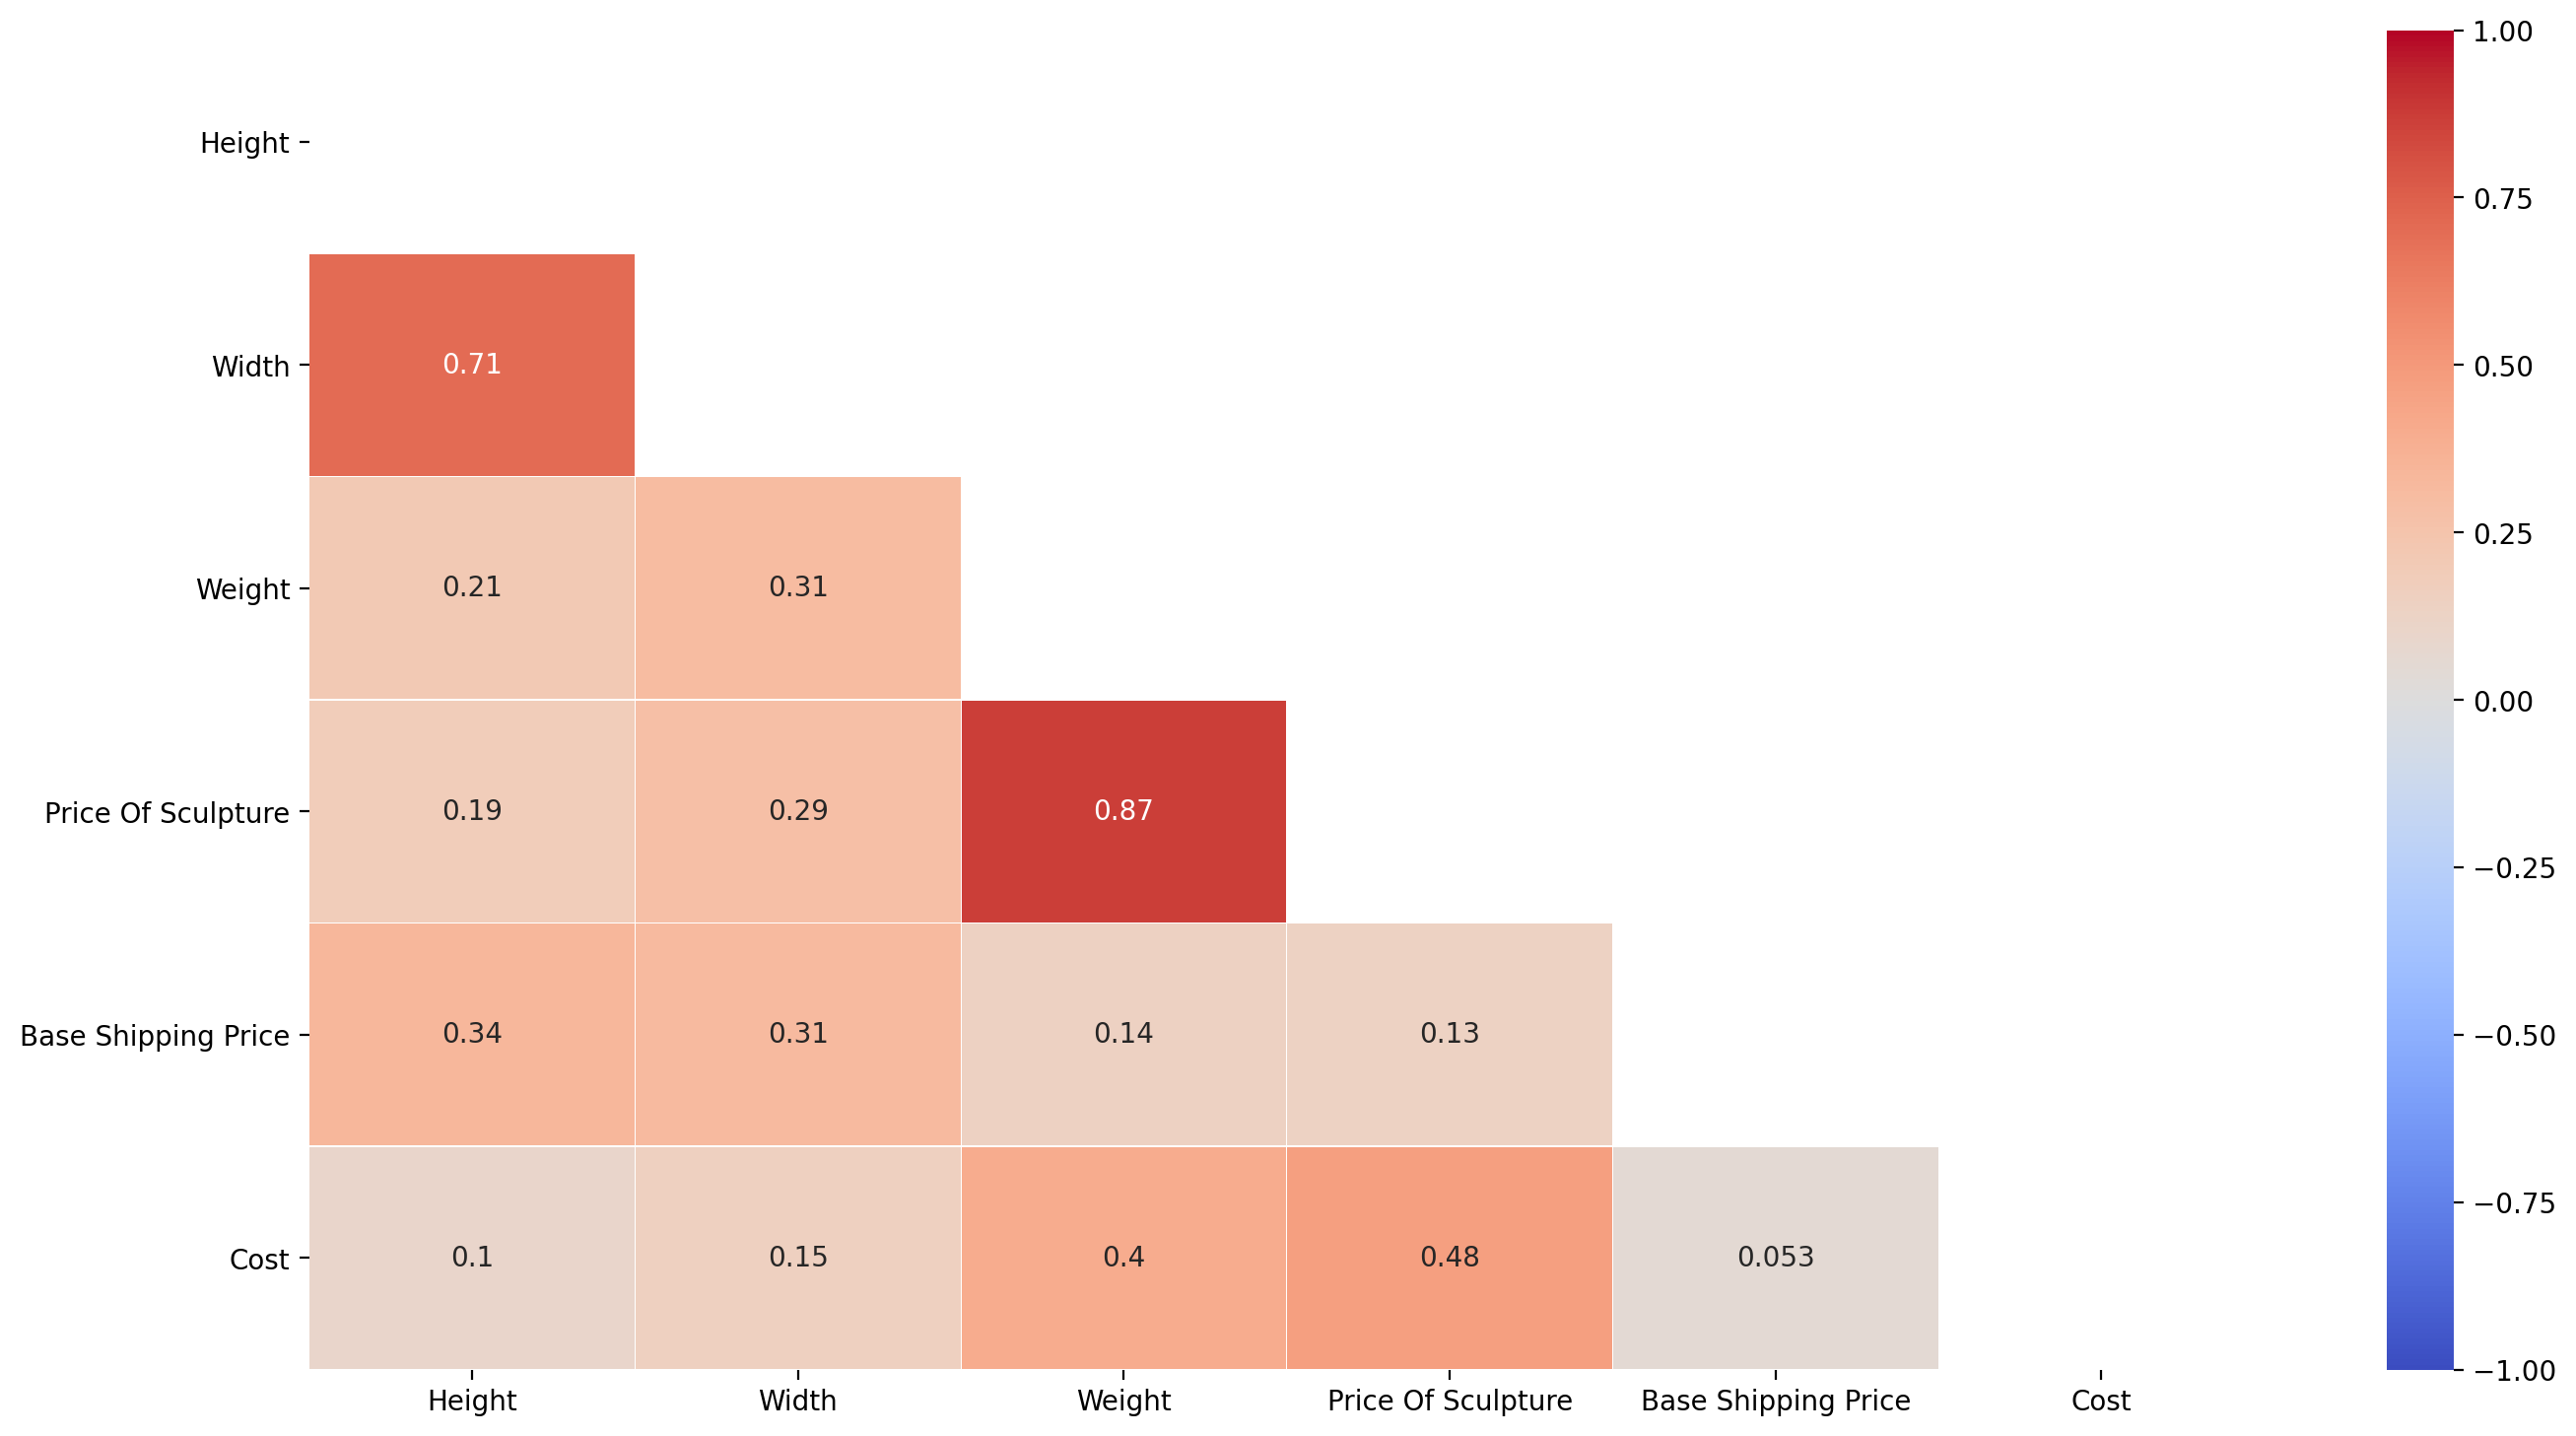

<IPython.core.display.Javascript object>

In [108]:
plt.figure(figsize=(16, 9), dpi=200)
corr_plot = train_df[
    ["Height", "Width", "Weight", "Price Of Sculpture", "Base Shipping Price", "Cost"]
].corr()
mask = np.zeros_like(corr_plot, dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(
    corr_plot,
    square=False,
    linewidth=0.1,
    vmin=-1,
    vmax=1,
    cmap="coolwarm",
    annot=True,
    mask=mask,
)
plt.show()

The following variables are correlated, based on their coefficient of correlation:
1. Height and Width
2. Weight and Price of Sculpture

We can combine height and width in order to get area.

In [109]:
train_df["Area"] = train_df["Height"] * train_df["Width"]

<IPython.core.display.Javascript object>

In [110]:
test_df["Area"] = test_df["Height"] * test_df["Width"]

<IPython.core.display.Javascript object>

Similarly Weight and Price of Sculpture can be combined to get price per unit weight

In [111]:
train_df["Price per unit weight"] = train_df["Price Of Sculpture"] / train_df["Weight"]

<IPython.core.display.Javascript object>

In [112]:
test_df["Price per unit weight"] = test_df["Price Of Sculpture"] / test_df["Weight"]

<IPython.core.display.Javascript object>

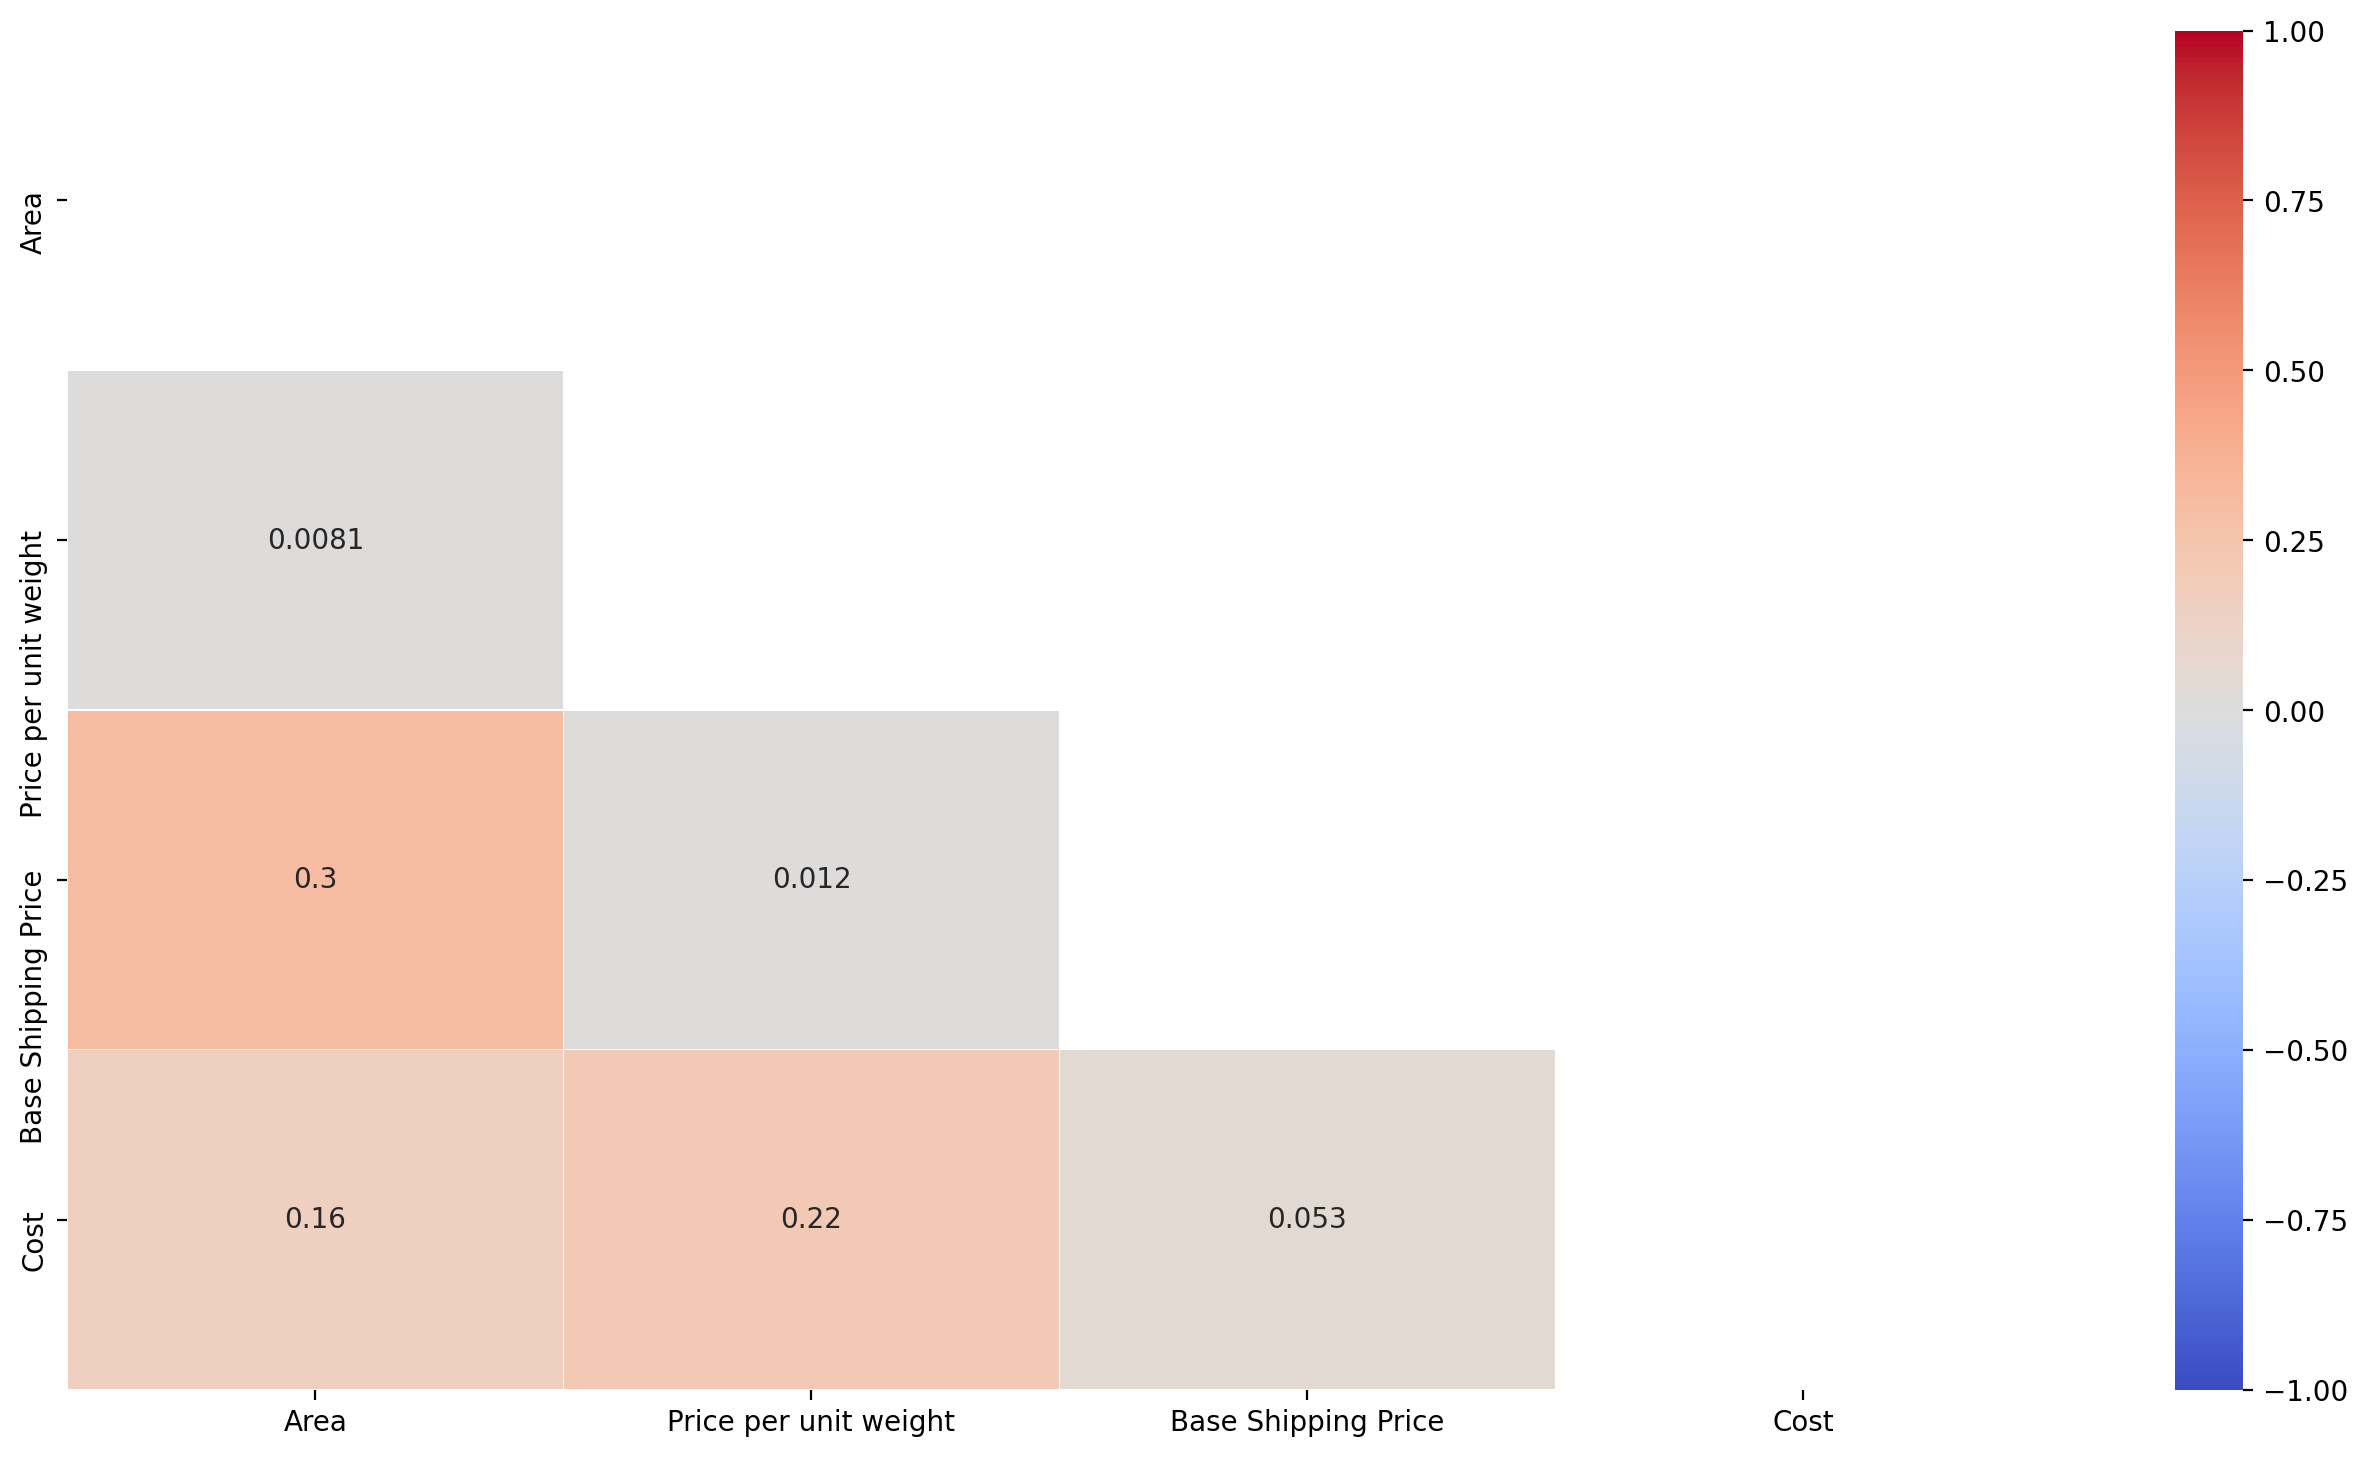

<IPython.core.display.Javascript object>

In [113]:
plt.figure(figsize=(16, 9), dpi=200)
corr_plot = train_df[
    ["Area", "Price per unit weight", "Base Shipping Price", "Cost"]
].corr()
mask = np.zeros_like(corr_plot, dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(
    corr_plot,
    square=False,
    linewidth=0.1,
    vmin=-1,
    vmax=1,
    cmap="coolwarm",
    annot=True,
    mask=mask,
)
plt.show()

In [114]:
train_df.to_csv("data/train_cleaned.csv", index=False)
test_df.to_csv("data/test_cleaned.csv", index=False)

<IPython.core.display.Javascript object>

## References

1. [The prevention and handling of the missing data](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3668100/)
2. [How to Handle Missing Data](https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4)
3. [Tuning the Random Forest in Python](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)